In [323]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Librerías

In [324]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from unidecode import unidecode
from rapidfuzz import process, fuzz
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# Análisis de datos

In [325]:
df = pd.read_csv('Data/pf_suvs_i302_1s2025.csv')
df = df.drop(df.columns[0], axis=1)
mask = df['Moneda'] == '$'
df.loc[mask, 'Precio'] = df.loc[mask, 'Precio'] / 1185
df.drop(columns=['Moneda'], inplace=True)
df.drop(columns = ['Tipo de carrocería'],inplace=True)
idx = df[df['Año'] == 436694.0].index
df.drop(idx, inplace=True)

In [326]:
df.info()    
df.describe(include='all')  

<class 'pandas.core.frame.DataFrame'>
Index: 18253 entries, 0 to 18253
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Marca                    18253 non-null  object 
 1   Modelo                   18253 non-null  object 
 2   Año                      18253 non-null  float64
 3   Versión                  18253 non-null  object 
 4   Color                    17864 non-null  object 
 5   Tipo de combustible      18253 non-null  object 
 6   Puertas                  18253 non-null  float64
 7   Transmisión              18238 non-null  object 
 8   Motor                    18215 non-null  object 
 9   Con cámara de retroceso  4691 non-null   object 
 10  Kilómetros               18253 non-null  object 
 11  Título                   18253 non-null  object 
 12  Precio                   18253 non-null  float64
 13  Descripción              18253 non-null  object 
 14  Tipo de vendedor         18

,Marca,Modelo,Año,Versión,Color,Tipo de combustible,Puertas,Transmisión,Motor,Con cámara de retroceso,Kilómetros,Título,Precio,Descripción,Tipo de vendedor
count,18253,18253,18253.000000,18253,17864,18253,18253.000000,18238,18215,4691,18253,18253,18253.000000,18253,18253
unique,47,137,NaN,2072,70,8,NaN,4,271,2,2175,2220,NaN,12141,3
top,Ford,Ecosport,NaN,1.6 Exclusive Cvt,Gris,Nafta,NaN,Automática,1.6,Sí,0.0,Nissan Kicks 1.6 Exclusive Cvt,NaN,El vendedor no incluyó una descripción del pro...,concesionaria
freq,2161,1569,NaN,320,5468,16066,NaN,12281,4132,3731,4237,320,NaN,2260,8509
mean,NaN,NaN,2018.983619,NaN,NaN,NaN,18.168027,NaN,NaN,NaN,NaN,NaN,27598.044551,NaN,NaN
std,NaN,NaN,5.514331,NaN,NaN,NaN,891.790545,NaN,NaN,NaN,NaN,NaN,20297.864206,NaN,NaN
min,NaN,NaN,1981.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,100.421941,NaN,NaN
25%,NaN,NaN,2016.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,16033.755274,NaN,NaN
50%,NaN,NaN,2019.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,23500.000000,NaN,NaN
75%,NaN,NaN,2024.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,32489.450633,NaN,NaN


In [327]:
df.isnull().sum()     

Marca                          0
Modelo                         0
Año                            0
Versión                        0
Color                        389
Tipo de combustible            0
Puertas                        0
Transmisión                   15
Motor                         38
Con cámara de retroceso    13562
Kilómetros                     0
Título                         0
Precio                         0
Descripción                    0
Tipo de vendedor               0
dtype: int64

In [328]:
df['Puertas'] = df['Puertas'].replace(60252.0, np.nan)

# distribución de años

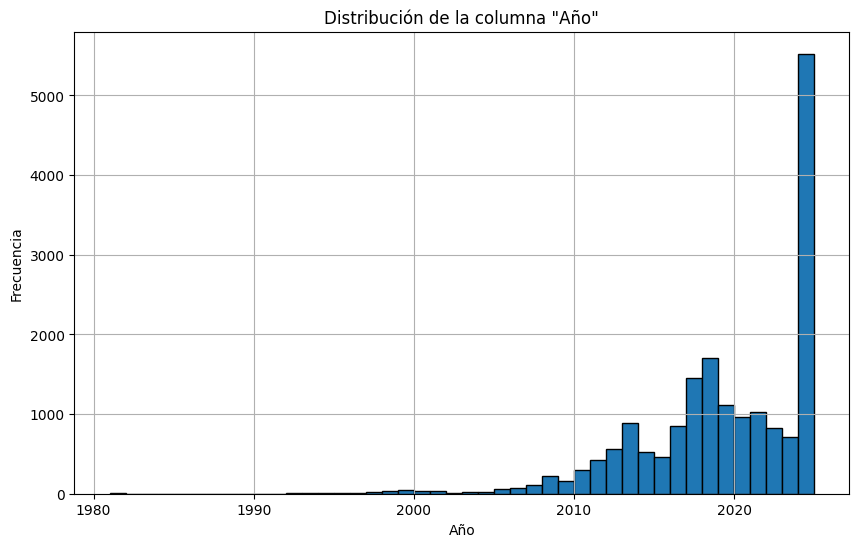

In [329]:
plt.figure(figsize=(10, 6))
plt.hist(df["Año"], bins=44, edgecolor='black')
plt.title(f'Distribución de la columna "{"Año"}"')
plt.xlabel("Año")
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Hay pocas muestras de autos viejos, capaz estaria bueno nivelarlas con alguno de los metodos que habiamos dado

# distribución puertas

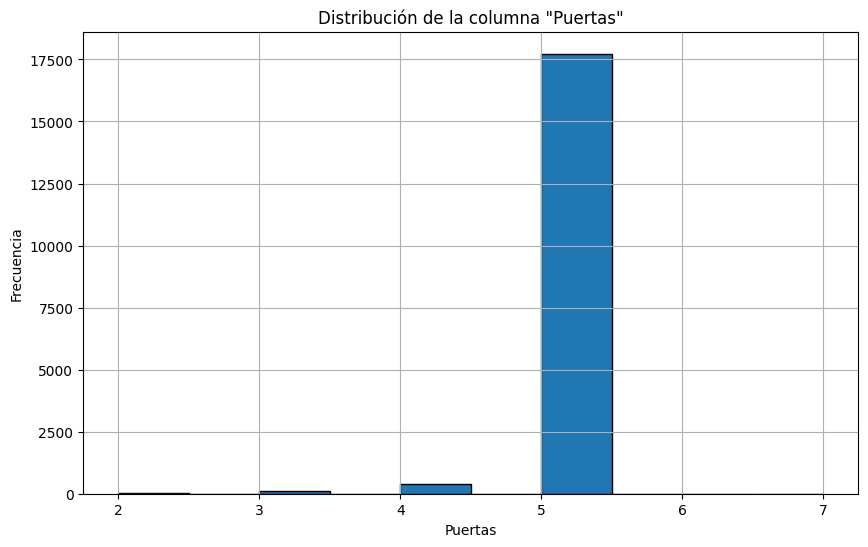

In [330]:
plt.figure(figsize=(10, 6))
plt.hist(df["Puertas"], bins=10, edgecolor='black')
plt.title(f'Distribución de la columna "{"Puertas"}"')
plt.xlabel("Puertas")
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Creo que no existen vehiculos de 2, 4, 6 o 7 puertas, habria que chequear eso. 

# distribucion precio

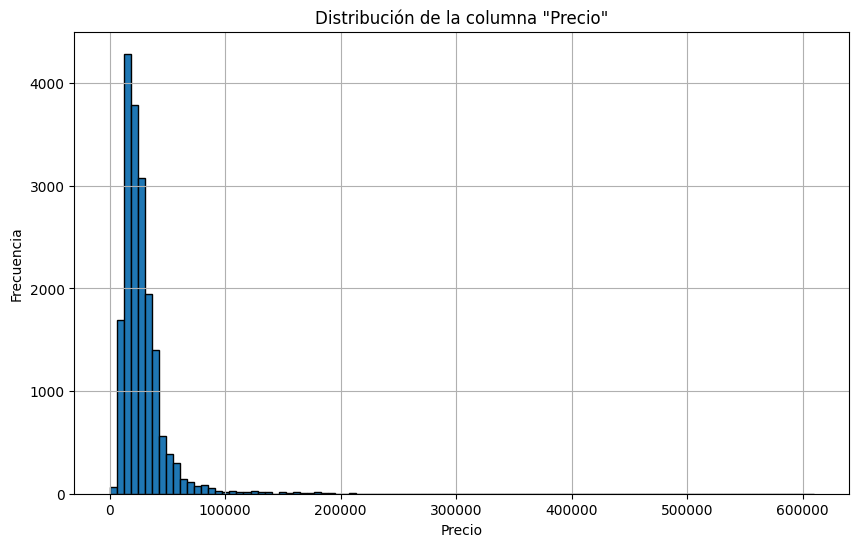

In [331]:
plt.figure(figsize=(10, 6))
plt.hist(df["Precio"], bins=100, edgecolor='black')
plt.title(f'Distribución de la columna "{"Precio"}"')
plt.xlabel("Precio")
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [332]:
df["Precio"].describe()  


count     18253.000000
mean      27598.044551
std       20297.864206
min         100.421941
25%       16033.755274
50%       23500.000000
75%       32489.450633
max      610000.000000
Name: Precio, dtype: float64

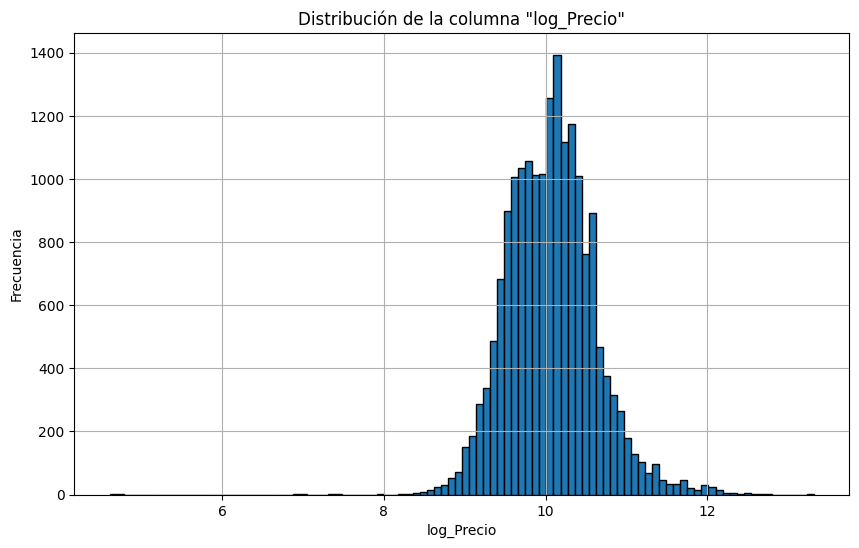

Número de outliers: 187


In [333]:
df["log_Precio"] = np.log(df["Precio"])
plt.figure(figsize=(10, 6))
plt.hist(df["log_Precio"], bins=100, edgecolor='black')
plt.title(f'Distribución de la columna "{"log_Precio"}"')
plt.xlabel("log_Precio")
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

mu = df["log_Precio"].mean()
sigma = df["log_Precio"].std()

outliers = df[np.abs(df["log_Precio"] - mu) > 3 * sigma]
print(f"Número de outliers: {len(outliers)}")

In [334]:
df= df[np.abs(df["log_Precio"] - mu) <= 3 * sigma].copy()
df["Precio"] = np.exp(df["log_Precio"])


# codificacion

In [ ]:
mappings = {
    'Con cámara de retroceso': {'No': 0, 'Sí': 1},
    'Transmisión': {
        'Automática': 0,
        'Manual': 1,
        'Automática secuencial': 2,
        'Semiautomática': 3
    }
}

for col, mapping in mappings.items():
    code_col = col.replace(' ', '_') + '_code'
    df[code_col] = df[col].map(mapping)

enc = OrdinalEncoder()
df[['Modelo_code', 'Version_code']] = enc.fit_transform(df[['Modelo', 'Versión']])

imputer = KNNImputer(n_neighbors=5, weights='uniform')
cols_to_impute = ['Modelo_code', 'Año', 'Version_code'] + [c.replace(' ', '_') + '_code' for c in mappings]
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

for col, mapping in mappings.items():
    code_col = col.replace(' ', '_') + '_code'
    df[code_col] = np.round(df[code_col]).astype(int)
    inv_map = {v: k for k, v in mapping.items()}
    df[col] = df[code_col].map(inv_map)

df['Puertas'] = df['Puertas'].replace(60252.0, np.nan)
imputer = KNNImputer(n_neighbors=5)
cols = ['Modelo_code', 'Año','Version_code','Puertas']
df[cols] = imputer.fit_transform(df[cols])
df['Puertas'] = np.round(df['Puertas']).astype(int)

aux_cols = ['Modelo_code', 'Version_code'] + [c.replace(' ', '_') + '_code' for c in mappings]
df.drop(aux_cols, axis=1, inplace=True)

print(df['Puertas'].value_counts(dropna=False))
print(df['Con cámara de retroceso'].value_counts(dropna=False))
print(df['Transmisión'].value_counts(dropna=False))

df['Kilómetros'] = (
    df['Kilómetros']
      .str.replace(r'\s*km$', '', regex=True)  
      .str.replace(r'\.', '', regex=True)      
      .astype(float)
)
print( df['Kilómetros'].value_counts(dropna=False))

In [ ]:
def normalize(text):
    return unidecode(text).lower().strip()

df['color_norm'] = df['Color'].astype(str).apply(normalize)

canonical = [
    'Blanco','Negro','Gris','Azul','Rojo','Verde','Amarillo',
    'Naranja','Celeste','Bordo','Marrón','Violeta','Rosa',
    'Plateado','Dorado','otro','cafe'
]
canonical_lower = [c.lower() for c in canonical]

overrides = {
    'cafe':                         'cafe',
    'blanco nacre tricapa':         'Blanco',
    'steel_blue':                   'Azul',
    'gris selenium':                'Gris',
    'summit white':                 'Blanco',
    'mineralweiss metallic':        'Gris',
    'skyscraper grau metallic':     'Gris',
    'granite crysta bc':            'Gris',
    'prata bari+tet vulc':          'Plateado',
    'champaing':                    'Dorado',
    'noir perla nera':              'Negro',
    'black meet kettle':            'Negro',
    'granite crystal bc':           'Gris',
    'blue':                         'Azul',
    'beige techo negro':            'Marrón',
    'rojo sunset metalizado':       'Rojo',
    'gris artense':                 'Gris',
    'moundaz':                      'otro',
    'blanco banchisa bicolor negro':'Blanco'
}

def map_color(name):
    if name in overrides:
        return overrides[name]
    match, score, _ = process.extractOne(name, canonical_lower, scorer=fuzz.token_sort_ratio)
    if score >= 40:
        return canonical[canonical_lower.index(match)]
    return None

df['color_estandar'] = df['color_norm'].apply(map_color)
print( df['color_estandar'].value_counts(dropna=False))
df['Color']=df['color_estandar']
df.drop(columns=['color_estandar','color_norm'], inplace=True)

color_estandar
Gris        5464
Blanco      4801
Negro       2916
Plateado    1425
Rojo        1116
Azul        1106
Naranja      454
Marrón       258
Dorado       191
Verde        135
Celeste       94
Violeta       33
Bordo         29
Amarillo      25
otro           8
Rosa           8
cafe           3
Name: count, dtype: int64


In [ ]:
canonical_brands = [
    'Ford','Volkswagen','Jeep','Chevrolet','Renault','Toyota','Peugeot','Nissan',
    'Citroën','BMW','Honda','Hyundai','Audi','Fiat','Chery','Kia',
    'Mercedes-Benz','Dodge','BAIC','Suzuki','Land Rover','Porsche',
    'Mitsubishi','Volvo','SsangYong','D.S.','Alfa Romeo','JAC','Jetour',
    'Haval','GWM','Lifan','Lexus','Isuzu','Subaru','Daihatsu','Mini','otro'
]
canonical_lower = [c.lower() for c in canonical_brands]

overrides = {
    'rrenault':               'Renault',
    'hiunday':                'Hyundai',
    'vol':                    'Volvo',
    'range rover':            'Land Rover',
    'ds automobiles':         'D.S.',
    'd.s':                    'D.S.',
    'd·s':                    'D.S.',
}
def map_brand(name):
    if name in overrides:
        return overrides[name]
    match, score, _ = process.extractOne(name, canonical_lower, scorer=fuzz.token_sort_ratio)
    if score >= 80:
        return canonical_brands[canonical_lower.index(match)]
    return 'otro'

df['brand_norm'] = df['Marca'].apply(normalize)
df['Marca_limpia'] = df['brand_norm'].apply(map_brand)

df['Marca'] = df['Marca_limpia']

df.drop(columns=['brand_norm','Marca_limpia'], inplace=True)

print(df['Marca'].value_counts(dropna=False))


Marca
Ford             2155
Volkswagen       2036
Jeep             2020
Chevrolet        1749
Renault          1491
Toyota           1258
Peugeot          1250
Nissan           1059
Citroën           720
BMW               627
Honda             595
Hyundai           571
Audi              477
Fiat              365
Chery             344
Kia               290
Mercedes-Benz     262
Dodge             185
BAIC              165
Suzuki             76
Land Rover         59
Porsche            52
Mitsubishi         47
Volvo              39
D.S.               29
SsangYong          28
Alfa Romeo         24
JAC                19
Jetour             15
Haval               9
GWM                 9
otro                8
Lifan               7
Lexus               7
Isuzu               7
Subaru              5
Daihatsu            4
Mini                3
Name: count, dtype: int64


In [ ]:

df['modelo_norm'] = df['Modelo'].apply(normalize)

overrides_model = {
    'sw4':        'hilux sw4',
    'hilux sw4': 'hilux sw4',
    'x55':       'x5',
    'q5 sportback': 'q5 sportback',
    'q3 sportback': 'q3 sportback',
    'grand santa fe': 'santa fe'
}

df['modelo_final'] = df['modelo_norm'].map(lambda x: overrides_model.get(x, x))
df['Modelo'] = df['modelo_final']
df.drop(columns=['modelo_final','modelo_norm'], inplace=True)
print(df['Modelo'].value_counts())


Modelo
ecosport      1564
tracker       1511
2008          1144
duster        1047
compass        915
              ... 
terrano ii       2
sandero          2
f-pace           2
panamera         1
q8               1
Name: count, Length: 134, dtype: int64


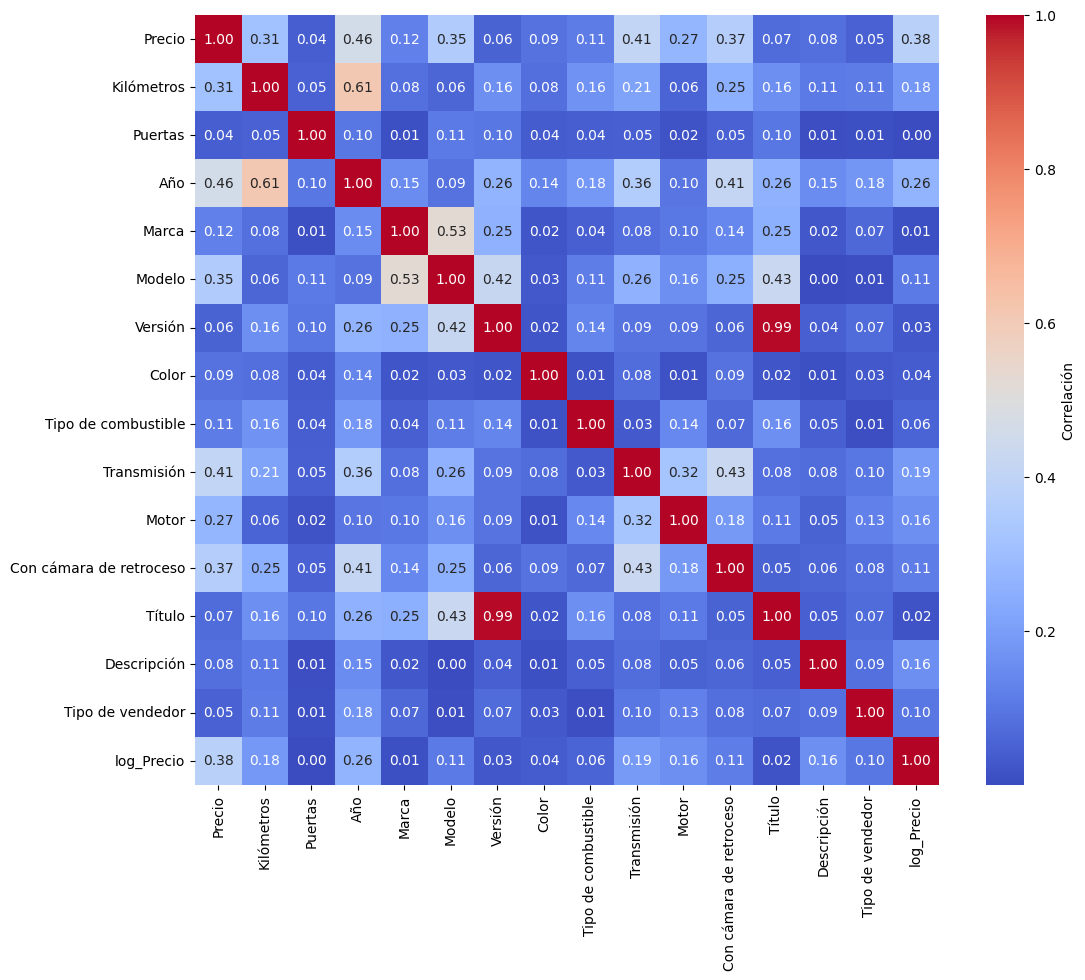

In [ ]:
todos = df.columns.tolist()

exclude = ['Año', 'Precio', 'Puertas', 'Kilómetros', 'log_precio']

categoricals = [c for c in todos if c not in exclude]

for col in categoricals:
    freqs = df[col].value_counts(normalize=True)
    df[f'{col}'] = df[col].map(freqs)

numeric_cols = ['Precio','Kilómetros','Puertas','Año']
freq_feats = [f'{col}' for col in categoricals]

df_corr = df[numeric_cols + freq_feats]

corr_matrix = df_corr.corr(method='pearson').abs() 

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            cbar_kws={'label': 'Correlación'})
plt.show()



Preparacion para el entrenamiento

In [ ]:
df.drop(columns=['Título','Descripción','Motor'], inplace=True)

df.to_csv('Data/pf_suvs_i302_1s2025_processed.csv', index=False,sep=',')  


Entrenamiento con una Regresion Lineal con Ridge

In [ ]:
numerical = ['Kilómetros','Año','Puertas']
X = df[numerical + freq_feats]
y = np.log(df['Precio'])

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

alphas = np.logspace(-3, 1, 13)
ridge_pipeline = make_pipeline(
    StandardScaler(),
    RidgeCV(
        alphas=alphas,
        scoring='neg_root_mean_squared_error',
        cv=5
    )
)

ridge_pipeline.fit(X_train_full, y_train_full)

best_alpha = ridge_pipeline.named_steps['ridgecv'].alpha_
print("Mejor α (λ) según CV:", best_alpha)

y_pred_log = ridge_pipeline.predict(X_test)

y_test_orig = np.exp(y_test)
y_pred_orig = np.exp(y_pred_log)

rmse_test = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2_test   = r2_score(y_test_orig, y_pred_orig)
print(f"Test RMSE (USD): {rmse_test:,.0f}")
print(f"Test R² :   {r2_test:.3f}")


Mejor α (λ) según CV: 0.001
Test RMSE (USD): 11,066
Test R² :   0.421


Entrenamiento con Gradient Boosting

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros GBR: {'subsample': 1.0, 'n_estimators': 500, 'min_samples_leaf': 20, 'max_depth': 5, 'learning_rate': 0.1}
GBR Test RMSE (USD): 4,257
GBR Test R² :   0.914


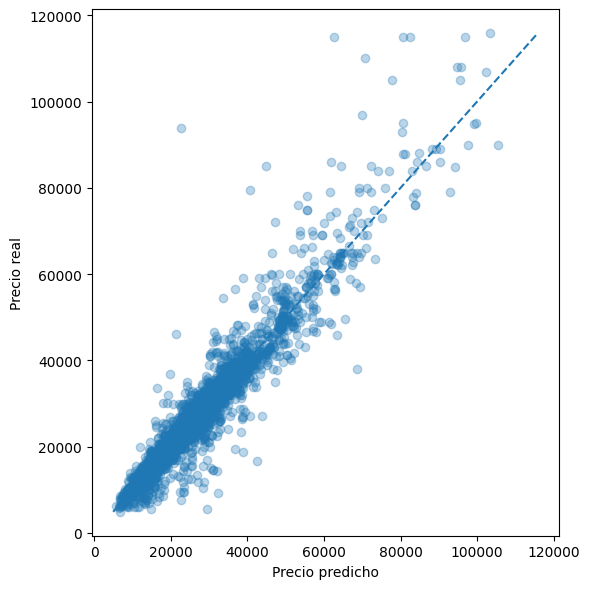

In [ ]:
X = df[numerical + freq_feats]
y = np.log(df['Precio'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=0)

param_dist = {
    'n_estimators':    [100, 300, 500],
    'learning_rate':   [0.01, 0.05, 0.1],
    'max_depth':       [3, 5, 7],
    'min_samples_leaf':[20, 50, 100],
    'subsample':       [0.8, 1.0]
}

search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    random_state=0,
    verbose=1
)
search.fit(X_train, y_train)

best_gbr = search.best_estimator_
print("Mejores parámetros GBR:", search.best_params_)

y_pred_log  = best_gbr.predict(X_test)
y_test_orig = np.exp(y_test)
y_pred_orig = np.exp(y_pred_log)

rmse_test = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2_test   = r2_score(y_test_orig, y_pred_orig)
print(f"GBR Test RMSE (USD): {rmse_test:,.0f}")
print(f"GBR Test R² :   {r2_test:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_pred_orig, y_test_orig, alpha=0.3)
mn, mx = y_test_orig.min(), y_test_orig.max()
plt.plot([mn, mx], [mn, mx], ls='--')
plt.xlabel("Precio predicho")
plt.ylabel("Precio real")
plt.tight_layout()
plt.show()
